# MNIST Experiment Analysis

This notebook analyzes and compares the results of different MNIST training runs with various activation functions and dropout configurations.

In [2]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
from datetime import datetime

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [5]:
def load_experiment_data(base_path: str) -> pd.DataFrame:
    """Load all experiment data from a directory into a DataFrame"""
    results = []
    base_path = Path(base_path)
    
    for exp_dir in base_path.glob("*"):
        if not exp_dir.is_dir():
            continue
            
        stats_file = exp_dir / 'run_stats.json'
        if not stats_file.exists():
            continue
            
        with open(stats_file, 'r') as f:
            data = json.load(f)
            
        # Extract key information
        exp_data = {
            'run_name': data['metadata']['run_name'],
            'activation_type': data['metadata']['model_config']['activation_type'],
            'dropout_prob': data['metadata']['model_config']['dropout_prob'],
            'learning_rate': data['metadata']['training_config']['learning_rate'],
            'batch_size': data['metadata']['training_config']['batch_size'],
            'num_parameters': data['metadata']['model_config']['num_parameters'],
            'best_val_acc': data['metadata']['final_metrics']['best_val_acc'],
            'test_acc': data['metadata']['final_metrics']['test_acc'],
            'best_val_loss': data['metadata']['final_metrics']['best_val_loss'],
            'test_loss': data['metadata']['final_metrics']['test_loss'],
            'training_duration': data['metadata']['final_metrics']['training_duration'],
            'total_epochs': data['metadata']['final_metrics']['total_epochs'],
            'train_loss_history': data['train_loss'],
            'val_loss_history': data['val_loss'],
            'train_acc_history': data['train_acc'],
            'val_acc_history': data['val_acc'],
            # # 'weight_analysis': data['metadata']['weight_analysis'],
            # 'activation_analysis': data['metadata']['activation_analysis']
        }
        results.append(exp_data)
    
    return pd.DataFrame(results)

In [6]:
# Load data from both directories
base_experiments = load_experiment_data('constrained_activations')
dropout_experiments = load_experiment_data('constrained_activations_dropout')

# Add a column to distinguish between the two sets
base_experiments['experiment_type'] = 'Base'
dropout_experiments['experiment_type'] = 'With Dropout'

# Combine the datasets
all_experiments = pd.concat([base_experiments, dropout_experiments], ignore_index=True)

print(f"Total experiments analyzed: {len(all_experiments)}")
print(f"\nExperiment types:")
print(all_experiments.groupby(['experiment_type', 'activation_type']).size())

Total experiments analyzed: 20

Experiment types:
experiment_type  activation_type 
Base             LayerwiseSoftmax    4
                 ReLU                3
                 RescaledReLU        1
With Dropout     LayerwiseSoftmax    8
                 ReLU                2
                 RescaledReLU        2
dtype: int64


## 1. Overall Performance Comparison

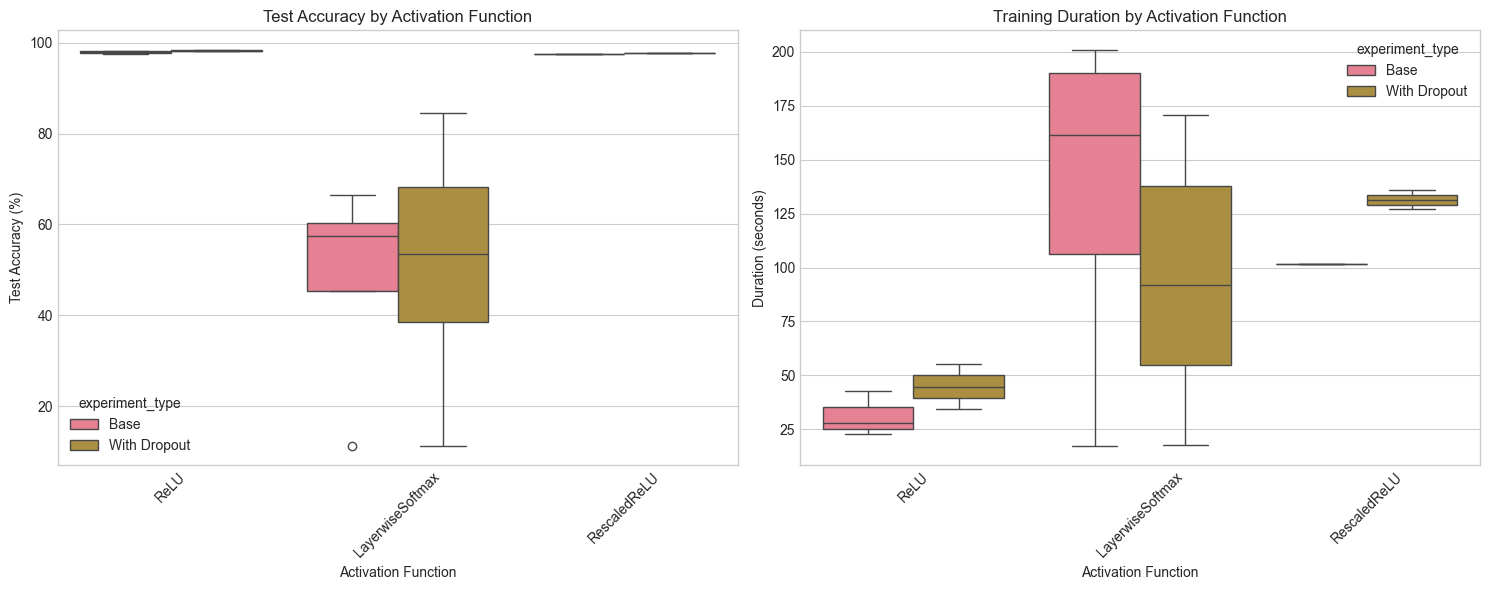

In [7]:
plt.figure(figsize=(15, 6))

# Test Accuracy Comparison
plt.subplot(1, 2, 1)
sns.boxplot(data=all_experiments, x='activation_type', y='test_acc', hue='experiment_type')
plt.xticks(rotation=45)
plt.title('Test Accuracy by Activation Function')
plt.xlabel('Activation Function')
plt.ylabel('Test Accuracy (%)')

# Training Duration Comparison
plt.subplot(1, 2, 2)
sns.boxplot(data=all_experiments, x='activation_type', y='training_duration', hue='experiment_type')
plt.xticks(rotation=45)
plt.title('Training Duration by Activation Function')
plt.xlabel('Activation Function')
plt.ylabel('Duration (seconds)')

plt.tight_layout()
plt.show()

## 2. Learning Curves Comparison

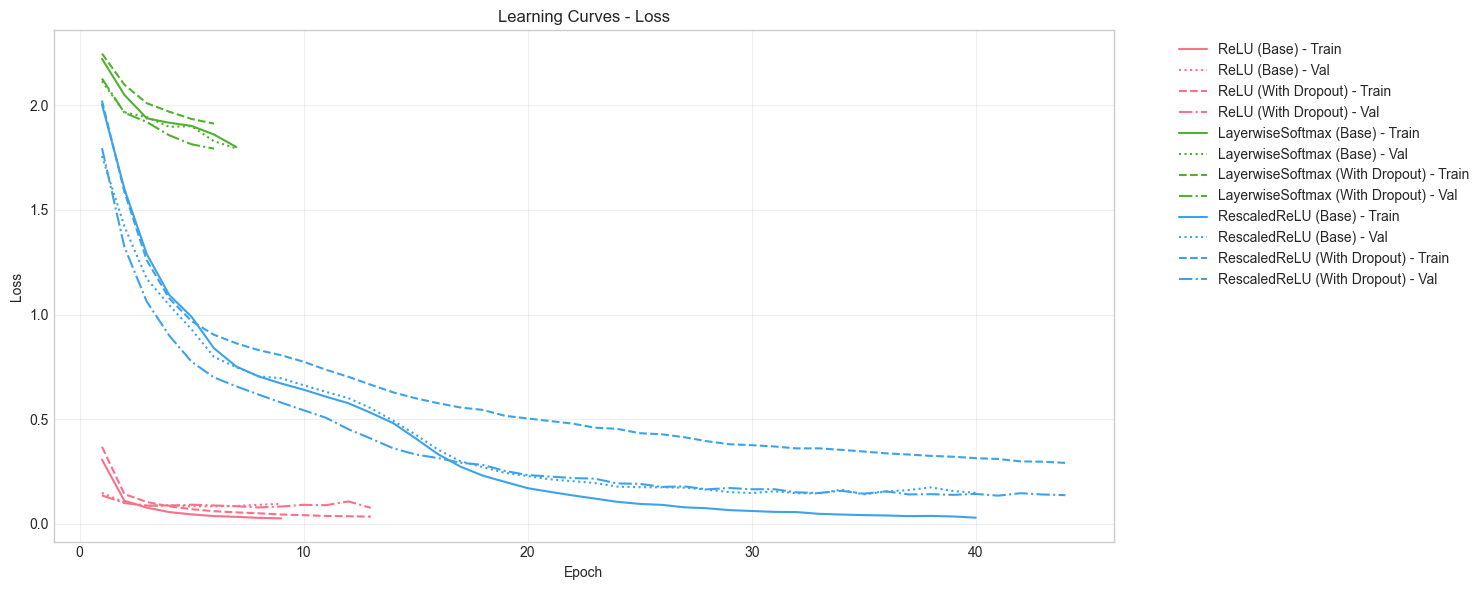

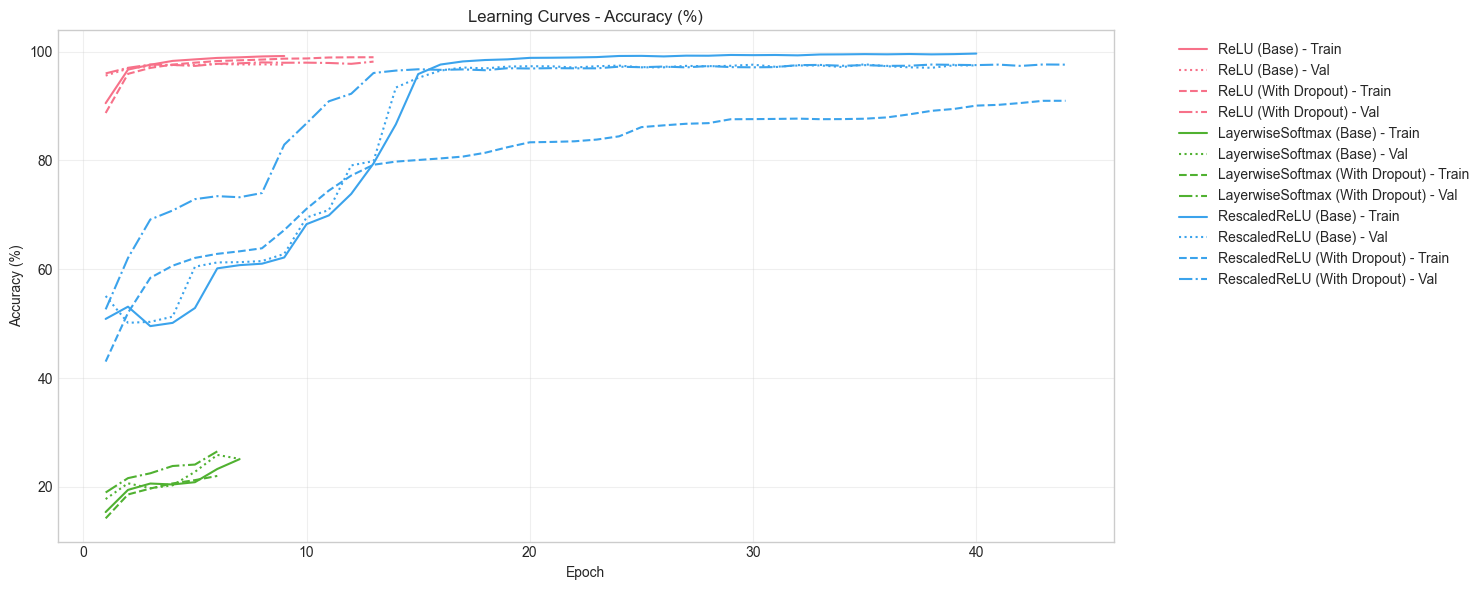

In [12]:
def plot_learning_curves(experiments: pd.DataFrame, metric: str = 'loss'):
    plt.figure(figsize=(15, 6))
    
    # Create a color palette for each activation type
    activation_types = experiments['activation_type'].unique()
    colors = sns.color_palette("husl", n_colors=len(activation_types))
    color_dict = dict(zip(activation_types, colors))
    
    # Plot separately for each activation type and experiment type
    for act_type in activation_types:
        for exp_type in ['Base', 'With Dropout']:
            subset = experiments[
                (experiments['activation_type'] == act_type) & 
                (experiments['experiment_type'] == exp_type)
            ]
            
            if len(subset) == 0:
                continue
            
            # Get the history data
            if metric == 'loss':
                train_histories = [row['train_loss_history'] for _, row in subset.iterrows()]
                val_histories = [row['val_loss_history'] for _, row in subset.iterrows()]
                ylabel = 'Loss'
            else:
                train_histories = [row['train_acc_history'] for _, row in subset.iterrows()]
                val_histories = [row['val_acc_history'] for _, row in subset.iterrows()]
                ylabel = 'Accuracy (%)'
            
            # Find minimum length to truncate all sequences
            min_length = min(min(len(h) for h in train_histories),
                           min(len(h) for h in val_histories))
            
            # Truncate and convert to numpy arrays
            train_histories = np.array([h[:min_length] for h in train_histories])
            val_histories = np.array([h[:min_length] for h in val_histories])
            
            # Calculate mean curves
            train_data = np.mean(train_histories, axis=0)
            val_data = np.mean(val_histories, axis=0)
            
            epochs = range(1, min_length + 1)
            color = color_dict[act_type]
            
            # Solid line for training, dashed for validation
            plt.plot(epochs, train_data, color=color, 
                    linestyle='-' if exp_type == 'Base' else '--',
                    label=f'{act_type} ({exp_type}) - Train')
            plt.plot(epochs, val_data, color=color, 
                    linestyle=':' if exp_type == 'Base' else '-.',
                    label=f'{act_type} ({exp_type}) - Val')
    
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(f'Learning Curves - {ylabel}')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot both loss and accuracy curves
plot_learning_curves(all_experiments, 'loss')
plot_learning_curves(all_experiments, 'accuracy')

## 3. Convergence Analysis

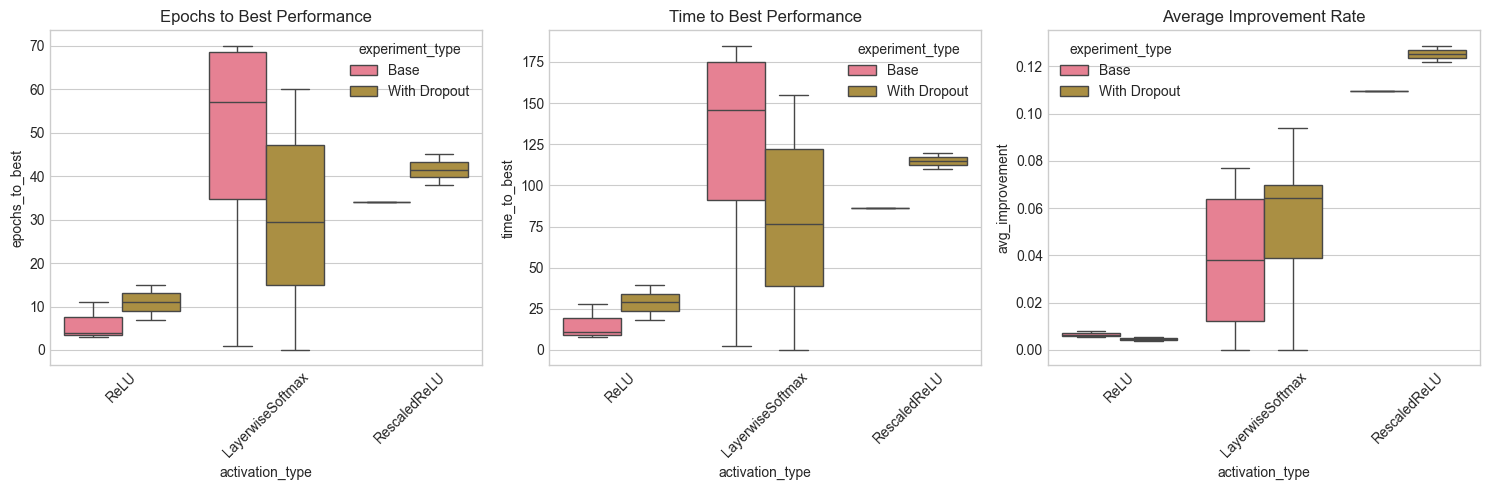

In [9]:
# Calculate convergence metrics
def calculate_convergence_metrics(row):
    val_loss = np.array(row['val_loss_history'])
    
    # Time to best validation loss
    best_epoch = np.argmin(val_loss)
    time_per_epoch = row['training_duration'] / row['total_epochs']
    time_to_best = best_epoch * time_per_epoch
    
    # Convergence speed (average improvement in first 10 epochs)
    initial_loss = val_loss[0]
    convergence_window = min(10, len(val_loss))
    avg_improvement = (initial_loss - val_loss[convergence_window-1]) / convergence_window
    
    return pd.Series({
        'epochs_to_best': best_epoch,
        'time_to_best': time_to_best,
        'avg_improvement': avg_improvement
    })

convergence_metrics = all_experiments.apply(calculate_convergence_metrics, axis=1)
all_experiments = pd.concat([all_experiments, convergence_metrics], axis=1)

# Plot convergence metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=all_experiments, x='activation_type', y='epochs_to_best', hue='experiment_type')
plt.xticks(rotation=45)
plt.title('Epochs to Best Performance')

plt.subplot(1, 3, 2)
sns.boxplot(data=all_experiments, x='activation_type', y='time_to_best', hue='experiment_type')
plt.xticks(rotation=45)
plt.title('Time to Best Performance')

plt.subplot(1, 3, 3)
sns.boxplot(data=all_experiments, x='activation_type', y='avg_improvement', hue='experiment_type')
plt.xticks(rotation=45)
plt.title('Average Improvement Rate')

plt.tight_layout()
plt.show()

## 4. Weight Distribution Analysis

In [ ]:
def analyze_weight_stats(experiments: pd.DataFrame):
    weight_stats = []
    
    for _, row in experiments.iterrows():
        for layer_name, stats in row['weight_analysis'].items():
            stats_entry = {
                'activation_type': row['activation_type'],
                'experiment_type': row['experiment_type'],
                'layer': layer_name,
                **stats
            }
            weight_stats.append(stats_entry)
    
    return pd.DataFrame(weight_stats)

weight_stats_df = analyze_weight_stats(all_experiments)

# Plot weight statistics
metrics = ['mean', 'std', 'norm', 'sparsity']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, metric in enumerate(metrics):
    sns.boxplot(data=weight_stats_df, x='activation_type', y=metric, 
                hue='experiment_type', ax=axes[idx])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
    axes[idx].set_title(f'Weight {metric.capitalize()} by Activation Function')

plt.tight_layout()
plt.show()

## 5. Activation Statistics Analysis

In [ ]:
def analyze_activation_stats(experiments: pd.DataFrame):
    activation_stats = []
    
    for _, row in experiments.iterrows():
        for layer_name, stats in row['activation_analysis'].items():
            stats_entry = {
                'activation_type': row['activation_type'],
                'experiment_type': row['experiment_type'],
                'layer': layer_name,
                **stats
            }
            activation_stats.append(stats_entry)
    
    return pd.DataFrame(activation_stats)

activation_stats_df = analyze_activation_stats(all_experiments)

# Plot activation statistics
metrics = ['avg_means', 'avg_stds', 'avg_sparsity']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, metric in enumerate(metrics):
    sns.boxplot(data=activation_stats_df, x='activation_type', y=metric, 
                hue='experiment_type', ax=axes[idx])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
    axes[idx].set_title(f'Activation {metric.replace("avg_", "").capitalize()}')

plt.tight_layout()
plt.show()

## 6. Summary Statistics

In [10]:
# Create summary table
summary = all_experiments.groupby(['activation_type', 'experiment_type']).agg({
    'test_acc': ['mean', 'std'],
    'training_duration': 'mean',
    'epochs_to_best': 'mean',
    'avg_improvement': 'mean'
}).round(3)

print("Summary Statistics:")
display(summary)

Summary Statistics:


test_acc         training_duration  \
                                     mean     std              mean   
activation_type  experiment_type                                      
LayerwiseSoftmax Base              48.210  24.948           135.147   
                 With Dropout      50.332  27.058            92.253   
ReLU             Base              97.890   0.348            31.227   
                 With Dropout      98.275   0.106            44.803   
RescaledReLU     Base              97.570     NaN           101.561   
                 With Dropout      97.780   0.000           131.429   

                                 epochs_to_best avg_improvement  
                                           mean            mean  
activation_type  experiment_type                                 
LayerwiseSoftmax Base                     46.25           0.038  
                 With Dropout             29.50           0.052  
ReLU             Base                      6.00           0.007  
                 With Dropout             11.00           0.005  
RescaledReLU     Base                     34.00           0.110  
                 With Dropout             41.50           0.125